In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tracked_object import TrackedObject

## Generate some data
We're going to try and track an object that makes a path through a building.

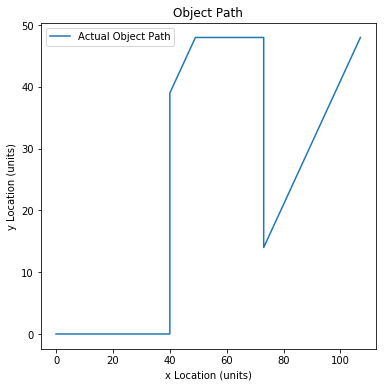

In [2]:
# A right hand turn
obj_x_pos = [i for i in range(40)] + [40 for i in range(40)]
obj_y_pos = [0 for i in range(40)] + [i for i in range(40)]
# a 45 degree turn
obj_x_pos += [obj_x_pos[-1] + i for i in range(10)]
obj_y_pos += [obj_y_pos[-1] + i for i in range(10)]
# a 45 degree turn
obj_x_pos += [obj_x_pos[-1] + i for i in range(25)]
obj_y_pos += [obj_y_pos[-1] for i in range(25)]
# a 90 degree turn
obj_x_pos += [obj_x_pos[-1] for i in range(35)]
obj_y_pos += [obj_y_pos[-1] - i for i in range(35)]
# a 120 degree turn
obj_x_pos += [obj_x_pos[-1] + i for i in range(35)]
obj_y_pos += [obj_y_pos[-1] + i for i in range(35)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(obj_x_pos, obj_y_pos, label='Actual Object Path')
ax.set_title("Object Path")
ax.set_xlabel("x Location (units)")
ax.set_ylabel("y Location (units)")
plt.legend()
plt.show()

## Create the object tracker and set up the Kalman Filter

In [3]:
# Using the TrackedObject class
to = TrackedObject()

# Create a P matrix that makes sense.
# Since we can trust the data exactly
# in this case, we can just use the
# identity matrix for P, Q and R.
P = np.matrix(np.identity(4))
Q = np.matrix(np.identity(4))
R = np.matrix(np.identity(4))

# We'll be using a standard 2D model
# including velocity such that the
# state vector looks like
# [x, y, xdot, ydot]
# and our measurement vector will include
# an updated velocity.
# In this case H can be the identity matrix.
H = np.matrix(np.identity(4))

# This matrix is standard - our predicted
# estimate is for the velocities to remain constant
# over the time step between measurements
# but for the positions to move by vdt.
F = np.matrix([ [1, 0, 1, 0], 
                [0, 1, 0, 1],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

# Since we know the location of the object
# exactly we can just set our initial state
# to be our second measurement (so we have
# some history with which to calculate
# velocity).
x = np.matrix([obj_x_pos[1], obj_y_pos[1], obj_x_pos[1]-obj_x_pos[0], obj_y_pos[1]-obj_y_pos[0]]).getT()
# Apply these matrices to the TrackedObject instance
to.configure_kalman_filter(x = x, P = P, Q = Q, R = R, H = H, F = F)


## Track the object.

In [4]:
# Set up the history vectors for visualisation purposes
est_x_pos = [x[0,0]]
est_y_pos = [x[1,0]]
for i in range(2, len(obj_x_pos)):
    # Take a measurement
    z_k = np.matrix([obj_x_pos[i], obj_y_pos[i], obj_x_pos[i]-obj_x_pos[i-1], obj_y_pos[i]-obj_y_pos[i-1]])
    z_k = z_k.getT()
    u_k = np.matrix([0])
    # Give it to the TrackedObject instance
    new_state = to.kf.update(u_k, z_k)
    est_x_pos.append(new_state[0,0])
    est_y_pos.append(new_state[1,0])

## Visualise the outcome.

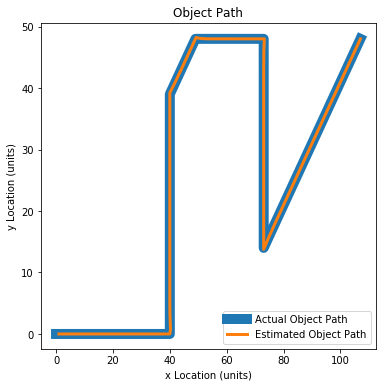

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(obj_x_pos, obj_y_pos, label='Actual Object Path', linewidth='10')
ax.plot(est_x_pos, est_y_pos, label='Estimated Object Path', linewidth='3')
ax.set_title("Object Path")
ax.set_xlabel("x Location (units)")
ax.set_ylabel("y Location (units)")
plt.legend()
plt.show()

## Now add noise.
The value in the Kalman filter is that it will still work even if there is a lot of noise in the system. To make this a difficult problem, we need to add noise to the measurements.

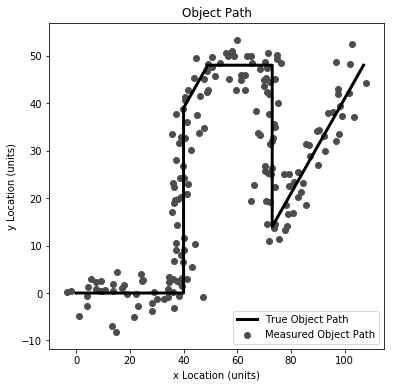

In [6]:
# Define the standard deviation
sigma = 3

# Create new noisy data (using different values for the noise
# in each dimension)
obj_x_pos_noisy, obj_y_pos_noisy = [], []
for i in range(len(obj_x_pos)):
    obj_x_pos_noisy.append(obj_x_pos[i] + np.random.normal(0, sigma, 1)[0])
    obj_y_pos_noisy.append(obj_y_pos[i] + np.random.normal(0, sigma, 1)[0])

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(obj_x_pos, obj_y_pos, label="True Object Path", color='black', linewidth='3')
ax.scatter(obj_x_pos_noisy, obj_y_pos_noisy, label='Measured Object Path', color='0.3')
ax.set_title("Object Path")
ax.set_xlabel("x Location (units)")
ax.set_ylabel("y Location (units)")
plt.legend()
plt.show()

## Recreate the object tracker and the Kalman Filter.
Because we have noise now, our P, Q and R matrices will all be different.

In [7]:
# We need an estimate of the variance.
# Let's say we have done some analysis of the
# data versus the "true" position and have a good
# idea of what we think the variance of the
# measurement is.
est_sigma = sigma + np.random.normal(0, 0.5, 1)

# We'll need to start with an estimate of the
# covariance matrix P.
# We'll assume that the x and y movements
# are independent (which they're not)
# and use the variance along the diagonal.
P = np.matrix((est_sigma**2)*np.identity(4))

# We are going to want to trust our state
# estimate more than our measurements
# since we can't account for directional
# changes, so make Q much smaller than P.
# Picking Q and R is a bit of a black art
# without some intense mathematics, so these
# values have been tuned to give the best results.

Q = 0.005*P
R = np.matrix((est_sigma**4) * np.identity(4))

# Since we know the location of the object
# we can just set our initial state
# to be our second measurement (so we have
# some history with which to calculate
# velocity).
x = np.matrix([obj_x_pos_noisy[1], 
               obj_y_pos_noisy[1], 
               obj_x_pos_noisy[1]-obj_x_pos_noisy[0], 
               obj_y_pos_noisy[1]-obj_y_pos_noisy[0]]).getT()

# Apply these matrices to the TrackedObject instance
to.configure_kalman_filter(x = x, P = P, Q = Q, R = R, H = H, F = F)

## Track the object.

In [8]:
# Set up the history vectors for visualisation purposes
est_x_pos = [x[0,0]]
est_y_pos = [x[1,0]]
for i in range(2, len(obj_x_pos)):
    # Take a measurement
    z_k = np.matrix([obj_x_pos_noisy[i], 
                     obj_y_pos_noisy[i], 
                     obj_x_pos_noisy[i]-obj_x_pos_noisy[i-1], 
                     obj_y_pos_noisy[i]-obj_y_pos_noisy[i-1]])
    z_k = z_k.getT()
    u_k = np.matrix([0])
    # Give it to the TrackedObject instance
    new_state = to.kf.update(u_k, z_k)
    est_x_pos.append(new_state[0,0])
    est_y_pos.append(new_state[1,0])

## Visualise the outcome.

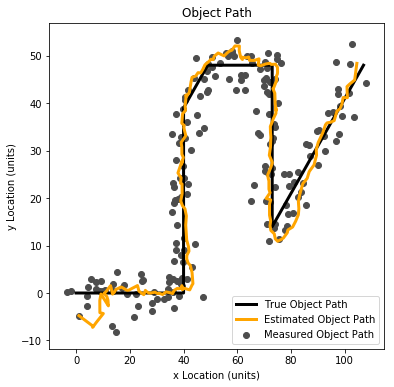

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(obj_x_pos, obj_y_pos, label="True Object Path", color='black', linewidth='3')
ax.scatter(obj_x_pos_noisy, obj_y_pos_noisy, label='Measured Object Path', color='0.3')
ax.plot(est_x_pos, est_y_pos, color='orange', label='Estimated Object Path', linewidth=3)
ax.set_title("Object Path")
ax.set_xlabel("x Location (units)")
ax.set_ylabel("y Location (units)")
plt.legend()
plt.show()

## But people don't walk in straight lines all the time...

One of the most obvious issues with using this tactic to track the object is that actual movement is non-linear and velocities are forever changing. Normally this would necessitate the use of the Extended Kalman Filter. In this case we have no model for the movement except instantaneously i.e., linearly, since we don't know when the object will change speed or direction. To test to see if close enough is good enough in this case (assuming a low dt), we'll try this same simulation on a sin wave.

## Generate some data.

In [10]:
sigma = 0.5
t = np.arange(0, 3, 0.004)
x_true = [np.sin(2*np.pi*i) for i in t]
x_noisy = [i + np.random.normal(0, sigma, 1)[0] for i in x_true]

## Set up the object tracker.

In [11]:
est_sigma = sigma + np.random.normal(0, sigma*0.01, 1)[0]
P = np.matrix((est_sigma**2)*np.identity(2))
# This Q matrix has had to be tuned to work for this system
Q = 0.00001*P
R = np.matrix((est_sigma**4) * np.identity(2))
x = np.matrix([x_noisy[1], x_noisy[1]-x_noisy[0]]).getT()
H = np.matrix(np.identity(2))
F = np.matrix([[1,1], [0, 1]])
to.configure_kalman_filter(x = x, P = P, Q = Q, R = R, H = H, F = F)

## Do the tracking.

In [12]:
# Set up the history vectors for visualisation purposes
est_x_pos = [x[0,0]]
for i in range(2, len(x_noisy)):
    # Take a measurement
    z_k = np.matrix([x_noisy[i], x_noisy[i] - x_noisy[i-1]]).getT()
    u_k = np.matrix([0])
               
    # Give it to the TrackedObject instance
    new_state = to.kf.update(u_k, z_k)
    est_x_pos.append(new_state[0,0])

## Visualise the outcome.

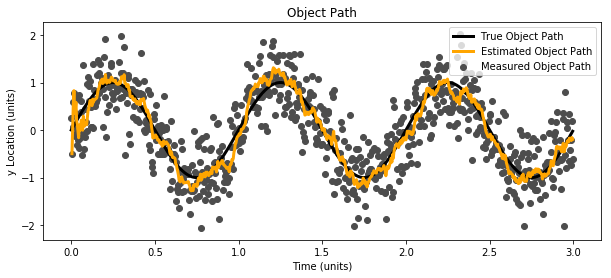

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t, x_true, label="True Object Path", color='black', linewidth='3')
ax.scatter(t, x_noisy, label='Measured Object Path', color='0.3')
ax.plot(t[1:], est_x_pos, color='orange', label='Estimated Object Path', linewidth=3)
ax.set_title("Object Path")
ax.set_xlabel("Time (units)")
ax.set_ylabel("y Location (units)")
plt.legend()
plt.show()

## Looks good to me.
We can see that while the response is slightly delayed, even with some significant noise in the system, a good estimate of the true object path can be found using a linear Kalman Filter. The accuracy of the estimate is heavily dependant on the measurement frequency.